# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are tasked to address the task of POS tagging.

<center>
    <img src="./images/pos_tagging.png" alt="POS tagging" />
</center>

In [28]:
#from google.colab import drive
#drive.mount('/content/drive')

In [29]:
#!cp -rf /content/drive/MyDrive/UNIBO/NLP/Assignments/Assignment-1/data ./
#!cp -rf /content/drive/MyDrive/UNIBO/NLP/Assignments/Assignment-1/images ./
#!cp /content/drive/MyDrive/UNIBO/NLP/Assignments/Assignment-1/data.csv ./

In [30]:
# dictionary to store the best models for each seed
# best losses keep track of the best loss for each seed after a training loop, so that we can re-train the model without 
# loosing the best model after the first iteration
# run this cell only once

best_models = {}
best_losses = {}

In [31]:
seed = 0
lower = True

# [Task 1 - 0.5 points] Corpus

You are going to work with the [Penn TreeBank corpus](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip).

**Ignore** the numeric value in the third column, use **only** the words/symbols and their POS label.

### Example

```Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8
```

### Splits

The corpus contains 200 documents.

   * **Train**: Documents 1-100
   * **Validation**: Documents 101-150
   * **Test**: Documents 151-199

### Instructions

* **Download** the corpus.
* **Encode** the corpus into a pandas.DataFrame object.
* **Split** it in training, validation, and test sets.

In [32]:
import os
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

random.seed(seed)
np.random.seed(seed)


data_folder = "./data"
def encode_dataset(dataset_name: str, to_lower: bool) -> pd.DataFrame:
  """
    Takes the dataset and encodes it in a pandas dataframe having six columns ['split', 'doc_id', 'sentence_num', 'words', 'tags', 'num_tokens']. Computes also unique tags set and unique words set and returns them with the dataframe.
  
  """
  print("Encoding dataset as pandas dataframe...")

  dataset_folder = os.path.join(data_folder+ "/dataset")
  
  dataframe_rows = []             #dataframe that will contain all the sentences in all the documents, each sentence as a list of word and a list of corresponding tags
  unique_tags = set()             
  unique_words = set()

  for doc in os.listdir(dataset_folder):
    if doc.endswith(".csv") or doc.endswith(".pkl"): continue
    doc_num = int(doc[5:8])
    doc_path = os.path.join(dataset_folder,doc)

    with open(doc_path, mode='r', encoding='utf-8') as file:
      df = pd.read_csv(file,sep='\t',header=None,skip_blank_lines=False)
      df.rename(columns={0:'word',1:"TAG",2:"remove"},inplace=True)
      df.drop("remove",axis=1,inplace=True)

      if to_lower: df['word'] = df["word"].str.lower() #set all words to lower case
      
      #create another column that indicate the group id by sentence 
      df["group_num"] = df.isnull().all(axis=1).cumsum()
      df.dropna(inplace=True)
      df.reset_index(drop=True, inplace=True)
      
      unique_tags.update(df['TAG'].unique())     #save all the unique tags in a set 
      unique_words.update(df['word'].unique())   #save all the unique words in a set 

      #generate sentence list in a document 
      df_list = [df.iloc[rows] for _, rows in df.groupby('group_num').groups.items()]
      for n,d in enumerate(df_list) :           #for each sentence create a row in the final dataframe
          dataframe_row = {
              "split" : 'train' if doc_num<=100 else ('val' if doc_num<=150  else 'test'),
              "doc_id" : doc_num,
              "sentence_num" : n,
              "words": d['word'].tolist(),
              "tags":  d['TAG'].tolist(),
              "num_tokens": len(d['word'])
          }
          dataframe_rows.append(dataframe_row)

  dataframe_path = os.path.join(data_folder, dataset_name)
  df_final = pd.DataFrame(dataframe_rows)
  df_final.to_csv(dataframe_path + ".csv")                      #save as csv to inspect

  print("Encoding completed!")
    
  return  df_final, unique_tags, unique_words

df, unique_tags, unique_words = encode_dataset("encoded_dataset", to_lower = lower)

print('Some words from the dataset:', random.choices(list(unique_words),k=15))
print('Some tags from the dataset:', random.choices(list(unique_tags),k=15))

print('\nencoded dataframe:')

Encoding dataset as pandas dataframe...
Encoding completed!
Some words from the dataset: ['companion', 'anxious', 'wertheim', 'fischer', '160', 'deny', 'fountain', 'smallest', 'creator', 'depression', 'upset', 'faultlessly', 'foster', 'think', 'speaking']
Some tags from the dataset: ['LS', 'UH', 'VBN', 'JJS', 'UH', 'FW', '$', 'UH', "''", 'WP', 'RP', 'MD', '``', 'TO', 'POS']

encoded dataframe:


In [33]:
df.sort_values("doc_id").groupby('split').head()

,split,doc_id,sentence_num,words,tags,num_tokens
2370,train,1,0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",18
2371,train,1,1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",13
921,train,2,0,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",26
453,train,3,0,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",36
454,train,3,1,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",32
623,val,101,1,"[for, the, agency, for, international, develop...","[IN, DT, NNP, IN, NNP, NNP, ,, NNS, VBD, $, CD...",51
636,val,101,14,"[rep., jerry, lewis, ,, a, conservative, calif...","[NNP, NNP, NNP, ,, DT, JJ, NN, ,, VBD, DT, NN,...",53
624,val,101,2,"[the, conference, approved, at, least, $, 55, ...","[DT, NN, VBD, IN, JJS, $, CD, CD, IN, JJ, NN, ...",48
622,val,101,0,"[a, house-senate, conference, approved, major,...","[DT, NNP, NN, VBD, JJ, NNS, IN, DT, NN, IN, JJ...",44
625,val,101,3,"[the, agreement, on, poland, contrasts, with, ...","[DT, NN, IN, NNP, VBZ, IN, DT, JJ, NNS, VBG, I...",37


In [34]:
from collections import OrderedDict
import pickle

dict_path = os.path.join(data_folder,'dictionaries.pkl') #path where dictionaries will be saved 

def build_dict(words : list[str], tags : list[str]): 
    """
        Builds 4 dictionaries word2int, int2word, tag2int, int2tag and returns them
    """
    
    word2int = OrderedDict()
    int2word = OrderedDict()

    for i, word in enumerate(words):
        word2int[word] = i+1           #plus 1 since the 0 will be used as tag token 
        int2word[i+1] = word

    tag2int = OrderedDict()
    int2tag = OrderedDict()

    for i, tag in enumerate(tags):
        tag2int[tag] = i+1
        int2tag[i+1] = tag
    
    print('saving dictionaries as pickle files')
    pickle_files = [word2int,int2word,tag2int,int2tag]
    
    with open(dict_path, 'wb') as f:
        pickle.dump(pickle_files, f)

    return word2int,int2word,tag2int,int2tag

word2int,int2word,tag2int,int2tag = build_dict(unique_words,unique_tags)

saving dictionaries as pickle files


In [35]:
indexed_df_path = os.path.join(data_folder, "indexed_dataset.pkl") #numberized dataframe path

def build_indexed_dataframe(word2int, tag2int, df):
    """
        Given the dictionaries word2int, tag2int and the dataframe, creates a dataframe were every word and tag is represented by its number and returns it
    """
    print('Initiating numberization of words and tags in dataframe')
    indexed_rows = []
    for words,tags in zip(df['words'],df['tags']):
        indexed_row = {'indexed_words':[word2int[word] for word in words ],'indexed_tags':[tag2int[tag] for tag in tags ]}
        indexed_rows.append(indexed_row)
    
    indexed_df = pd.DataFrame(indexed_rows)

    indexed_df.insert(0,'split',df['split'])
    indexed_df.insert(1,'num_tokens',df['num_tokens'])

    print('Numberization completed')

    return indexed_df


def check_dataframe_numberization(indexed_df, normal_df, int2word, int2tag) :
    """
       Checks if the numberized dataframe will lead to the normal dataframe usind the dictionaries int2word and int2tag
    """
    for n, (w_t, t_t) in enumerate(zip(indexed_df['indexed_words'],indexed_df['indexed_tags'])):
        if not normal_df.loc[n,'words'] == [int2word[indexed_word] for indexed_word in w_t]:
            print('words numberization gone wrong') 
            return False
        if not normal_df.loc[n,'tags'] == [int2tag[indexed_tag] for indexed_tag in t_t]:
            print('tags numberization gone wrong')
            return False 
    
    print('\nAll right with dataset numberization')
    print('Saving indexed dataframe')
    
    indexed_df.to_pickle(indexed_df_path)


indexed_df = build_indexed_dataframe(word2int,tag2int,df)
check_dataframe_numberization(indexed_df,df, int2word, int2tag)


Initiating numberization of words and tags in dataframe
Numberization completed

All right with dataset numberization
Saving indexed dataframe


# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [36]:
import torch
from torchtext.vocab import GloVe
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

embedding_dimension = 300

glove_embeddings = GloVe(name='6B', dim=embedding_dimension)

In [37]:
def build_embedding_matrix(emb_model, word2int):
    """
        Given the embedding model and the dict. word2int. If there is the embedding for the word, we add it to the embedding_matrix. In negative case we put a list of random values.
        Return the embedding matrix
    """
    #check_value_distribution_glove(emb_model)
   
    embedding_dimension = len(emb_model[0]) #how many numbers each emb vector is composed of                                                           
    embedding_matrix = np.zeros((len(word2int)+1, embedding_dimension), dtype=np.float32)   #create a matrix initialized with all zeros 

    for word, idx in word2int.items():
        if word in emb_model.stoi:
            embedding_matrix[idx] = emb_model[word]
        else:
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
            
    print('Saving embedding matrix')
    path = os.path.join(data_folder, "emb_matrix")
    np.save(path,embedding_matrix,allow_pickle=True)

    print("Embedding matrix shape: {}".format(embedding_matrix.shape))

    return embedding_matrix

embedding_matrix = build_embedding_matrix(glove_embeddings, word2int)

Saving embedding matrix
Embedding matrix shape: (10948, 300)


In [38]:
def load_data():
    """
        Loads the data "emb_matrix, indexed_dataset, word2int, int2word, tag2int, int2tag " and returns them
    """
    emb_matrix_path = os.path.join(data_folder,'emb_matrix.npy')
    indexed_dataset_path = os.path.join(data_folder,'indexed_dataset.pkl')
    dictionaries_path = os.path.join(data_folder,'dictionaries.pkl')

    if os.path.exists(emb_matrix_path) and os.path.exists(indexed_dataset_path):
        print('Loading embedding matrix')
        emb_matrix = np.load(emb_matrix_path,allow_pickle=True)
        print('Loading numberized dataset')
        indexed_dataset = pd.read_pickle(indexed_dataset_path)
        print('Loading dictionaries')
        with open(dictionaries_path, 'rb') as f:
            word2int,int2word,tag2int,int2tag = pickle.load(f)
        
        print('All data loaded')
    else:
        print('What you are looking for is not present in the folder')
        emb_matrix, indexed_dataset = None, None

    return emb_matrix, indexed_dataset, word2int, int2word, tag2int, int2tag

emb_matrix, indexed_dataset, word2int, int2word, tag2int, int2tag = load_data()

Loading embedding matrix
Loading numberized dataset
Loading dictionaries
All data loaded


# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

### Embedding layer

In [39]:
import torch.nn as nn
import torch.nn.functional as F

def create_emb_layer(weights_matrix, pad_idx = 0):
    """
        Creates and returns the embedding layer
    """
    matrix = torch.Tensor(weights_matrix)   #the embedding matrix 
    _ , embedding_dim = matrix.shape 
    emb_layer = nn.Embedding.from_pretrained(matrix, freeze=True, padding_idx = pad_idx)   #load pretrained weights in the layer and make it non-trainable 
    return emb_layer, embedding_dim

### Baseline model

In [40]:
class Baseline(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.bidirectional_layer = nn.LSTM(bidirectional=True, input_size=embedding_dimension, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)
        self.embedding_layer, self.embedding_dim = create_emb_layer(embedding_matrix)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer(packed_sentences)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer(output)
        output = F.log_softmax(output, dim=2)
        return output

        

### Model 1

In [41]:
class Model1(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.bidirectional_layer_1 = nn.LSTM(bidirectional=True, input_size=embedding_dimension, hidden_size=lstm_dimension, batch_first=True)
        self.bidirectional_layer_2 = nn.LSTM(bidirectional=True, input_size=lstm_dimension*2, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)
        self.embedding_layer, self.embedding_dim = create_emb_layer(embedding_matrix)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer_1(packed_sentences)
        packed_output, _ = self.bidirectional_layer_2(packed_output)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer(output)
        output = F.log_softmax(output, dim=2)
        return output

### Model 2

In [42]:
class Model2(nn.Module):
    def __init__(self, lstm_dimension, dense_dimension):
        super().__init__()
        self.bidirectional_layer = nn.LSTM(bidirectional=True, input_size=embedding_dimension, hidden_size=lstm_dimension, batch_first=True)
        self.dense_layer_1 = nn.Linear(in_features=lstm_dimension*2, out_features=dense_dimension)
        self.dense_layer_2 = nn.Linear(in_features=dense_dimension, out_features=dense_dimension)
        self.embedding_layer, self.embedding_dim = create_emb_layer(embedding_matrix)

    def forward(self, sentences, sentences_length):
        embedded_sentences = self.embedding_layer(sentences)
        packed_sentences = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentences_length, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.bidirectional_layer(packed_sentences)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        output = self.dense_layer_1(output)
        output = self.dense_layer_2(output)
        output = F.log_softmax(output, dim=2)
        return output

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [43]:
from sklearn.metrics import f1_score

def accuracy_and_f1(y_pred, y_true):
    correct = y_pred.eq(y_true)          
    acc = correct.sum()/y_true.shape[0] 
    f1 = f1_score(y_true,y_pred,average='macro')
    return acc,f1

### Let's check our OOV tokens

In [44]:
def check_OOV_terms(embedding_model, unique_words, lower):
    oov_words = []
    int_oov_words = []

    if lower:
        words = set([x.lower() for x in unique_words])
    else: 
        words = unique_words

    for word in words:
        if word not in embedding_model.itos:
           oov_words.append(word) 
           int_oov_words.append(word2int[word]) 
    
    print("Total number of unique words in dataset:",len(words))
    print(oov_words)
    print("Total OOV terms: {0} ({1:.2f}%)".format(len(oov_words), (float(len(oov_words)) / len(words))*100))
    print("Some OOV terms:",random.sample(oov_words,15))
    
    return oov_words, int_oov_words

oov_words, int_oov_words = check_OOV_terms(glove_embeddings, unique_words, lower)

Total number of unique words in dataset: 10947
['propagandizes', 'contingency-fee', 'mariotta', 'uzi-model', 'higher-salaried', 'near-limit', 'twin-jet', 'moleculon', '100-megabyte', '236.74', '352.9', '14,821', 'co-developers', 'tarwhine', 'anti-china', 'energy-services', '69-point', 'anti-morning-sickness', 'norwick', 'amphobiles', 'crystal-lattice', 'telephone-information', 'pennview', '3\\/4', 'savers\\/investors', '170,262', 'double-c', 'information-services', 'buy-outs', 'rope-sight', 'one-country', 'summer\\/winter', '37-a-share', 'takeover-stock', 'retin-a', 'industrial-production', 'incentive-bonus', 'top-yielding', '26,956', 'disputado', 'fetal-tissue', '127.03', 'sub-segments', 'micronite', 'bread-and-butter', 'replacement-car', 'bottom-line', 'money-market', '341.20', 'sogo-shosha', 'certin', 'gingl', 'early-retirement', 'lightning-fast', 'achievement-test', 'ballantine\\/del', 'school-improvement', 'church-goers', '449.04', 'financial-services', 'million-a-year', 'credit-r

As we can see the number of OOV words is very high (31.29% of the total words in the corpus). So, we have to find a way to deal with them.<br>
A good idea could be to use lowercased words, in fact in this way the number of OOV decreases to 6.18%, but we have to be careful because we could lose some information. <br>
For example, the word "Pierre" is a name, but "pierre" is a noun. So, we have to find a way to deal with this problem.<br>
We decided to test the model with the two different approaches and see which one is better.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [45]:
def initialize_weights(model):
    for _, param in model.named_parameters():
        if isinstance(model, nn.LSTM) or isinstance(model, nn.Linear):
            nn.init.normal_(param.data, mean = 0, std = 0.1)

In [46]:
def number_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [47]:
def get_to_be_masked_tags():
    punctuation_tags = ['$', '``', '.', ',', '#', 'SYM', ':', "''",'-RRB-','-LRB-']   #tags to be masked 
    token_punctuation = [tag2int[tag] for tag in punctuation_tags]
    return torch.LongTensor(token_punctuation+[0])

to_mask = get_to_be_masked_tags()

def reshape_and_mask(predictions,targets): 
    non_masked_elements = torch.isin(targets, to_mask, invert=True)
    
    return predictions[non_masked_elements],targets[non_masked_elements]


In [48]:
from torch.utils.data import Dataset, DataLoader

class PosDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
        self.sentence_lengths = [len(sentence) for sentence in self.text]
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
            label = self.labels[idx]
            text = self.text[idx]
            sample = (text, label, self.sentence_lengths[idx])
            return sample


def collate_fn(data):
    return ([x[0] for x in data], [x[1] for x in data], [x[2] for x in data])


def create_dataloaders(b_s : int):
    train_df = indexed_dataset[indexed_dataset['split'] == 'train'].reset_index(drop=True)      
    val_df = indexed_dataset[indexed_dataset['split'] == 'val'].reset_index(drop=True)
    test_df = indexed_dataset[indexed_dataset['split'] == 'test'].reset_index(drop=True)

    #create DataframeDataset objects for each split 
    train_dataset = PosDataset(train_df.iloc[:,2],train_df.iloc[:,3])
    val_dataset = PosDataset(val_df.iloc[:,2],val_df.iloc[:,3])
    test_dataset = PosDataset(test_df.iloc[:,2],test_df.iloc[:,3])

    train_dataloader = DataLoader(train_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)
    test_dataloader = DataLoader(test_dataset, batch_size=b_s, shuffle=True, collate_fn= collate_fn)

    return train_dataloader,val_dataloader,test_dataloader 

In [49]:
batch_size = 16

tr_dl, val_dl, test_dl = create_dataloaders(batch_size)

In [50]:
import torch.nn.utils.rnn as rnn
import time

def train(model, epochs, loss_function, dataloader, optimizer, scheduler, name, padding_value = 0):
    model.train()
    best_epoch_loss = np.inf
    if seed in best_losses.keys():
        if name in best_losses[seed].keys():
            best_epoch_loss = best_losses[seed][name]
    for epoch in range(epochs):
        start_time = time.time()
        total_epoch_loss = 0
        for sentences, pos, s_len in dataloader:
            optimizer.zero_grad()
            
            tensor_sentences = [torch.LongTensor(s) for s in sentences]
            tensor_pos = [torch.LongTensor(p) for p in pos]

            padded_sentences = rnn.pad_sequence(tensor_sentences, batch_first = True, padding_value = 0)
            padded_pos = rnn.pad_sequence(tensor_pos, batch_first = True, padding_value=padding_value)

            predicted = model(padded_sentences, s_len)

            predicted = predicted.view(-1,predicted.shape[-1])    
            targets = padded_pos.view(-1)

            predicted, targets = reshape_and_mask(predicted, targets)

            loss = loss_function(predicted, targets)
            loss.backward()
            optimizer.step()
            total_epoch_loss += loss.item()
        if total_epoch_loss < best_epoch_loss:
            # print(f'New best model for {name}, loss: {total_epoch_loss:.2f}')
            best_epoch_loss = total_epoch_loss
            if seed not in best_models.keys():
                best_models[seed] = {}
            best_models[seed][name] = model.state_dict()
        scheduler.step(total_epoch_loss)
        elapsed = time.time() - start_time 
        print(f'Train epoch [{epoch+1}/{epochs}] loss: {total_epoch_loss:.2f} time: {elapsed:.2f}s')

def evaluate(model, loss_function, dataloader, padding_value=0):
    model.eval()
    tot_pred , tot_targ = torch.LongTensor(), torch.LongTensor()
    epoch_loss = 0
    for sentences, pos, s_len in dataloader:
        tensor_sentences = [torch.LongTensor(s) for s in sentences]
        tensor_pos = [torch.LongTensor(p) for p in pos]

        padded_sentences = rnn.pad_sequence(tensor_sentences, batch_first = True, padding_value = 0)
        padded_pos = rnn.pad_sequence(tensor_pos, batch_first = True, padding_value=padding_value)

        predicted = model(padded_sentences, s_len)
        predicted = predicted.view(-1,predicted.shape[-1])    
        targets = padded_pos.view(-1)

        predicted, targets = reshape_and_mask(predicted, targets)

        loss = loss_function(predicted, targets)

        predicted = predicted.argmax(dim=1)

        tot_pred = torch.cat((tot_pred,predicted))
        tot_targ = torch.cat((tot_targ,targets))

        epoch_loss += loss.item()
    full_accuracy, full_f1 = accuracy_and_f1(tot_pred,tot_targ)
    print(f'Eval: loss: {epoch_loss:.2f} accuracy: {full_accuracy:.2f} f1: {full_f1:.2f}')
    return full_accuracy, full_f1, tot_pred, tot_targ

In [51]:
def load_best_model(model, name):
    model.load_state_dict(best_models[seed][name])
    return model

In [52]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

loss_function = CrossEntropyLoss()

lstm_dimension = 16
dense_dimension = len(unique_tags)+1


baseline_model = Baseline(lstm_dimension, dense_dimension)
optimizer_baseline = torch.optim.AdamW(baseline_model.parameters(), lr=0.001)
scheduler_baseline = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_baseline, patience=2, verbose=True)
baseline_model.apply(initialize_weights);

double_lstm_model = Model1(lstm_dimension, dense_dimension)
optimizer_double_lstm = torch.optim.AdamW(double_lstm_model.parameters(), lr=0.001)
scheduler_double_lstm = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_double_lstm, patience=2, verbose=True)
double_lstm_model.apply(initialize_weights);

double_dense_model = Model2(lstm_dimension, dense_dimension)
optimizer_double_dense = torch.optim.AdamW(double_dense_model.parameters(), lr=0.001)
scheduler_double_dense = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_double_dense, patience=2, verbose=True)
double_dense_model.apply(initialize_weights);

In [53]:
print(f'Number of parameters in baseline model: {number_parameters(baseline_model)}')
print(f'Number of parameters in double lstm model: {number_parameters(double_lstm_model)}')
print(f'Number of parameters in double dense model: {number_parameters(double_dense_model)}')

Number of parameters in baseline model: 42222
Number of parameters in double lstm model: 48622
Number of parameters in double dense model: 44384


In [54]:
epochs = 80

train(baseline_model, epochs, loss_function, tr_dl, optimizer_baseline, scheduler_baseline, name='baseline')
best_model_baseline = load_best_model(baseline_model, name='baseline')

Train epoch [1/80] loss: 343.81 time: 5.29s
Train epoch [2/80] loss: 220.63 time: 4.53s
Train epoch [3/80] loss: 158.76 time: 4.71s
Train epoch [4/80] loss: 125.50 time: 4.20s
Train epoch [5/80] loss: 105.30 time: 4.25s
Train epoch [6/80] loss: 91.72 time: 4.24s
Train epoch [7/80] loss: 81.89 time: 4.31s
Train epoch [8/80] loss: 74.28 time: 4.40s
Train epoch [9/80] loss: 68.24 time: 4.23s
Train epoch [10/80] loss: 63.18 time: 4.13s
Train epoch [11/80] loss: 58.82 time: 4.20s
Train epoch [12/80] loss: 54.95 time: 4.09s
Train epoch [13/80] loss: 51.33 time: 4.26s
Train epoch [14/80] loss: 48.15 time: 4.52s
Train epoch [15/80] loss: 45.49 time: 5.01s
Train epoch [16/80] loss: 42.96 time: 4.51s
Train epoch [17/80] loss: 40.65 time: 4.13s
Train epoch [18/80] loss: 38.53 time: 4.30s
Train epoch [19/80] loss: 36.62 time: 3.95s
Train epoch [20/80] loss: 34.67 time: 4.10s
Train epoch [21/80] loss: 33.17 time: 4.10s
Train epoch [22/80] loss: 31.79 time: 4.21s
Train epoch [23/80] loss: 30.38 time

In [55]:
epochs = 50

train(double_lstm_model, epochs, loss_function, tr_dl, optimizer_double_lstm, scheduler_double_lstm, name='double_lstm')
best_model_double_lstm = load_best_model(double_lstm_model, name='double_lstm')

Train epoch [1/50] loss: 368.44 time: 7.38s
Train epoch [2/50] loss: 290.80 time: 7.25s
Train epoch [3/50] loss: 224.90 time: 7.40s
Train epoch [4/50] loss: 170.28 time: 7.21s
Train epoch [5/50] loss: 131.77 time: 7.26s
Train epoch [6/50] loss: 107.59 time: 8.33s
Train epoch [7/50] loss: 90.45 time: 7.53s
Train epoch [8/50] loss: 77.55 time: 7.60s
Train epoch [9/50] loss: 67.82 time: 7.28s
Train epoch [10/50] loss: 59.88 time: 7.43s
Train epoch [11/50] loss: 53.71 time: 7.31s
Train epoch [12/50] loss: 48.40 time: 8.35s
Train epoch [13/50] loss: 43.98 time: 8.49s
Train epoch [14/50] loss: 40.21 time: 7.44s
Train epoch [15/50] loss: 36.87 time: 7.76s
Train epoch [16/50] loss: 33.97 time: 8.87s
Train epoch [17/50] loss: 31.54 time: 7.81s
Train epoch [18/50] loss: 29.23 time: 7.54s
Train epoch [19/50] loss: 27.36 time: 7.50s
Train epoch [20/50] loss: 25.45 time: 7.70s
Train epoch [21/50] loss: 23.79 time: 7.32s
Train epoch [22/50] loss: 22.44 time: 8.62s
Train epoch [23/50] loss: 21.12 tim

In [56]:
epochs = 50

train(double_dense_model, epochs, loss_function, tr_dl, optimizer_double_dense, scheduler_double_dense, name='double_dense')
best_model_double_dense = load_best_model(double_dense_model, name='double_dense')

Train epoch [1/50] loss: 327.57 time: 3.99s
Train epoch [2/50] loss: 169.16 time: 3.91s
Train epoch [3/50] loss: 110.24 time: 3.91s
Train epoch [4/50] loss: 82.60 time: 4.32s
Train epoch [5/50] loss: 66.92 time: 4.09s
Train epoch [6/50] loss: 56.85 time: 4.00s
Train epoch [7/50] loss: 49.06 time: 4.05s
Train epoch [8/50] loss: 43.50 time: 4.09s
Train epoch [9/50] loss: 38.94 time: 4.19s
Train epoch [10/50] loss: 35.05 time: 3.95s
Train epoch [11/50] loss: 31.79 time: 3.96s
Train epoch [12/50] loss: 28.86 time: 4.23s
Train epoch [13/50] loss: 26.31 time: 4.16s
Train epoch [14/50] loss: 24.34 time: 4.36s
Train epoch [15/50] loss: 22.46 time: 4.12s
Train epoch [16/50] loss: 20.57 time: 3.97s
Train epoch [17/50] loss: 19.28 time: 3.96s
Train epoch [18/50] loss: 17.80 time: 4.10s
Train epoch [19/50] loss: 16.60 time: 4.14s
Train epoch [20/50] loss: 15.40 time: 4.09s
Train epoch [21/50] loss: 14.50 time: 4.02s
Train epoch [22/50] loss: 13.56 time: 3.95s
Train epoch [23/50] loss: 12.67 time: 

In [57]:
baseline_accuracy, baseline_f1, baseline_pred, baseline_targ = evaluate(best_model_baseline, loss_function, val_dl)

Eval: loss: 38.16 accuracy: 0.88 f1: 0.76


In [58]:
double_lstm_accuracy, double_lstm_f1, double_lstm_pred, double_lstm_targ = evaluate(double_lstm_model, loss_function, val_dl)

Eval: loss: 36.99 accuracy: 0.90 f1: 0.74


In [59]:
double_dense_accuracy, double_dense_f1, double_dense_pred, double_dense_targ = evaluate(double_dense_model, loss_function, val_dl)

Eval: loss: 51.25 accuracy: 0.89 f1: 0.76


# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

In [60]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import itemgetter
 
def build_classification_report(targ,pred,unique_tags):
    """
        Generate classification report 
    """
    report = classification_report(targ,pred,zero_division=0,output_dict=False,target_names=unique_tags)
    print(report)

def build_confusion_matrix(targ,pred,unique_tags):
    """
        Build confusion matrix and returns it as a dataframe
    """
    cf_matrix = confusion_matrix(targ, pred)
    df_cm = pd.DataFrame(cf_matrix, index = unique_tags, columns = unique_tags)  #put the confusion matrix in a pandas dataframe 
    #plot the confusion matrix as heatmap 
    plt.figure(figsize = (40,32))
    sn.heatmap(df_cm, annot=True, cmap="Blues", linewidths= 0.05, linecolor='white')
    return df_cm

def build_errors_dictionary(df_cm):
    """
        Create a dictionary which contains, for each true tag a list of wrong predicted tags and the number of wrong predictions
    """
    errors = {}
    for true_tag,row in df_cm.iterrows():    #loop on the rows of the dataframe 

        tag_errors = []
        for pred_tag, occurrences in row.items() :     #loop on each column of that specific row 
            if not pred_tag==true_tag and occurrences!=0 : 
                tag_errors.append((pred_tag,occurrences))
        
        tag_errors.sort(key = itemgetter(1),reverse=True)   #sort it so that the tag that is more mistaken for the correct one is the first one to appear on the left 

        if tag_errors:     
            errors[true_tag] = tag_errors     #put it in the dict only if there are actually errors 

    errors = dict(sorted(errors.items(), key = lambda item : item[1][0][1],reverse=True))    #sort the dictionary in order to have the more wrongly classified tags on top 

    #pretty print 
    print('true_TAG --> (pred_TAG, n_times)\n')
    for k,v in errors.items():
        print(k,'-->',*v)

def get_tag_distribution(indexed_df: pd.DataFrame):
    """
        Count number of occurrences of each TAG in the train set 
    """
    tag_frequency = {}
    df_temp = indexed_df[indexed_df['split'] == 'train']
    for _ ,row in df_temp.iterrows():
        for key in row['indexed_tags']:
            tag_frequency[int2tag[key]] = tag_frequency.get(int2tag[key],0) + 1

    return dict(sorted(tag_frequency.items(), key=lambda item: item[1], reverse = True))

true_TAG --> (pred_TAG, n_times)

NNP --> ('NN', 292) ('JJ', 136) ('NNS', 23) ('VBZ', 12) ('VBN', 11) ('VBP', 7) ('CD', 7) ('VBG', 6) ('NNPS', 5) ('VB', 4) ('RB', 4) ('VBD', 4) ('IN', 2) ('WRB', 1) ('CC', 1) ('DT', 1) ('JJR', 1)
NN --> ('JJ', 225) ('NNP', 170) ('VBG', 64) ('NNS', 49) ('VB', 39) ('CD', 21) ('VBP', 15) ('VBN', 11) ('RB', 10) ('IN', 9) ('VBZ', 7) ('VBD', 7) ('DT', 5) ('RP', 3) ('WRB', 2) ('NNPS', 1) ('JJS', 1) ('JJR', 1)
JJ --> ('NN', 187) ('NNP', 62) ('RB', 43) ('NNS', 32) ('VBN', 27) ('VBG', 22) ('VB', 9) ('CD', 9) ('VBZ', 4) ('JJS', 3) ('IN', 2) ('VBD', 2) ('VBP', 1) ('NNPS', 1) ('DT', 1)
NNS --> ('NN', 76) ('JJ', 49) ('NNP', 35) ('VBN', 19) ('VBP', 16) ('VBZ', 13) ('VBG', 10) ('CD', 10) ('RB', 9) ('VBD', 9) ('NNPS', 9) ('VB', 6) ('JJS', 4) ('JJR', 2) ('PDT', 1) ('PRP', 1) ('DT', 1)
VBD --> ('VBN', 64) ('RB', 18) ('NN', 12) ('JJ', 11) ('NNS', 9) ('NNP', 4) ('VBP', 3) ('VB', 2) ('VBG', 2) ('IN', 1) ('MD', 1) ('NNPS', 1) ('JJR', 1)
VBN --> ('VBD', 64) ('JJ', 35) ('RB', 3

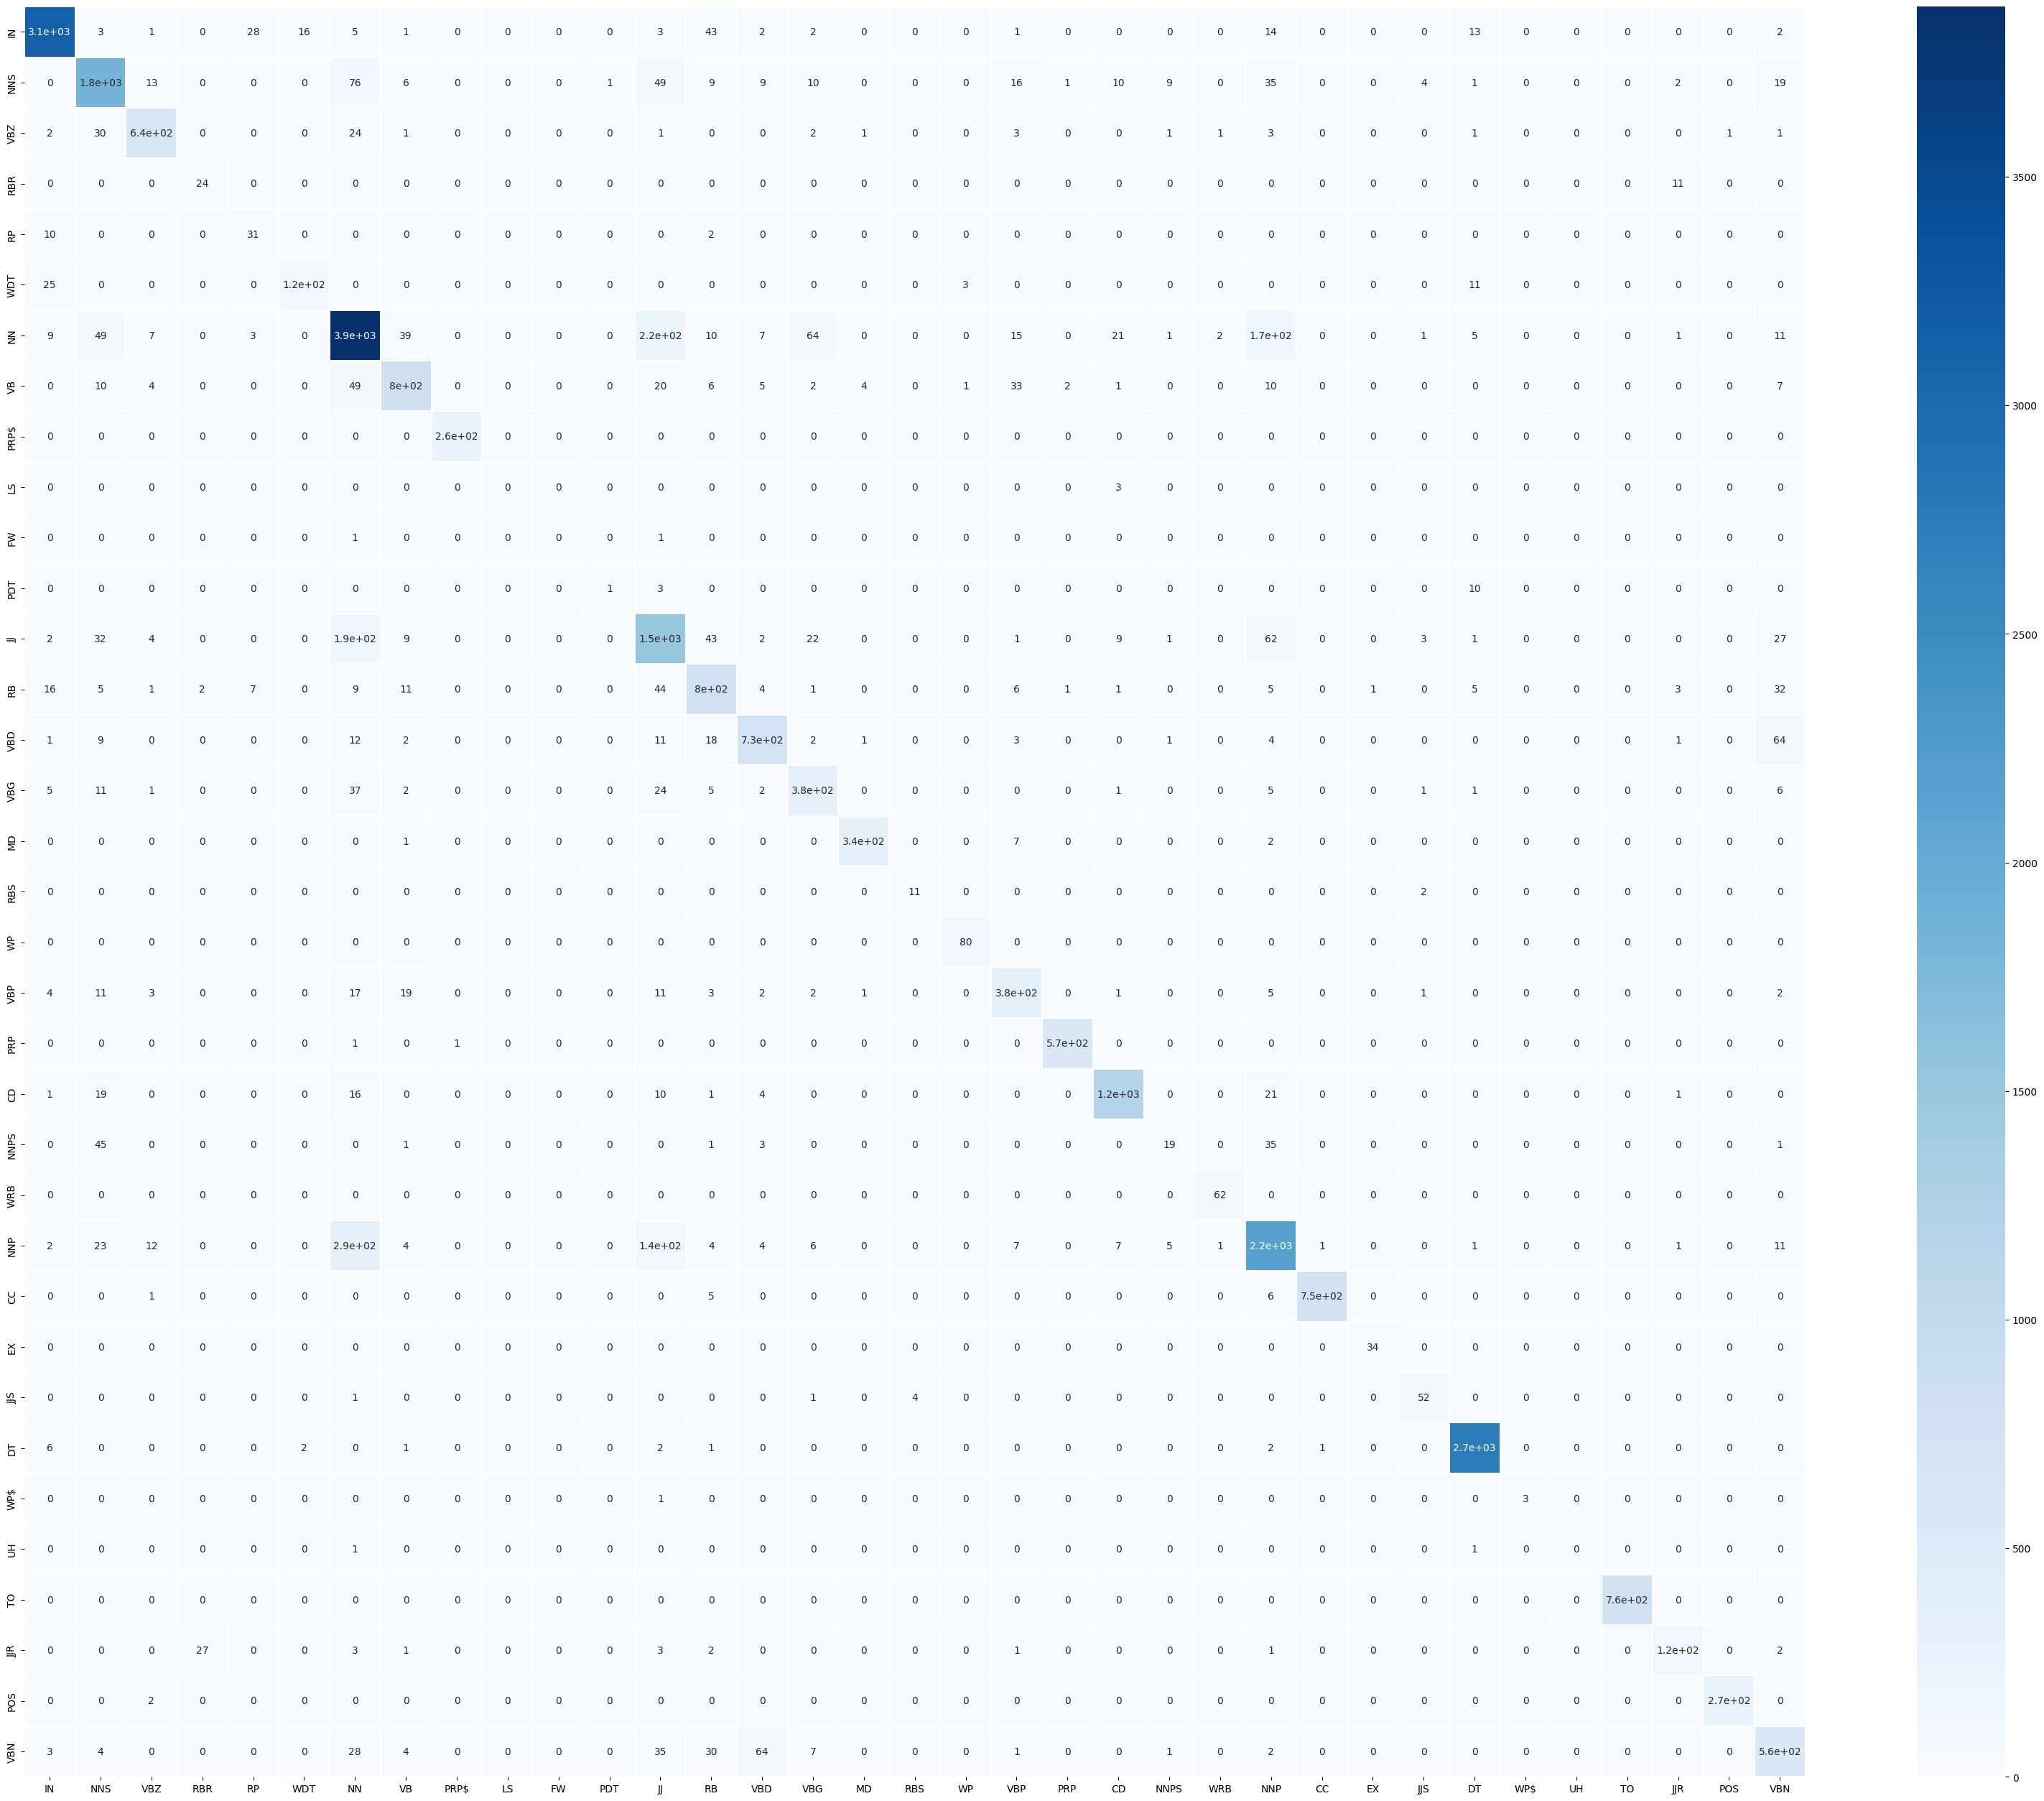

In [61]:
tags = [int2tag[i] for i in set(baseline_pred.tolist() + baseline_targ.tolist())]

df_cm = build_confusion_matrix(baseline_targ,baseline_pred,tags)

build_errors_dictionary(df_cm)

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End